In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.5'

### 准备数据

In [ ]:
import os, shutil

# defined directories of training set, validation set and test set
origin_train_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/train'
origin_test_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/test1'
base_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/base'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation_dir')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test_dir')
os.mkdir(test_dir)

# defined more specific directory with dog or cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# for feature extraction
test_image_dir = os.path.join(test_dir, 'test')
os.mkdir(test_image_dir)

# Copy images to the above defined directories
filenames = ['cat.{}.jpg'.format(i) for i in range(10000)]
for filename in filenames:
    src = os.path.join(origin_train_dir, filename)
    dst = os.path.join(train_cats_dir, filename)
    shutil.copyfile(src, dst)
    
filenames = ['dog.{}.jpg'.format(i) for i in range(10000)]
for filename in filenames:
    src = os.path.join(origin_train_dir, filename)
    dst = os.path.join(train_dogs_dir, filename)
    shutil.copyfile(src, dst)
    
filenames = ['cat.{}.jpg'.format(i) for i in range(10000, 12500)]
for filename in filenames:
    src = os.path.join(origin_train_dir, filename)
    dst = os.path.join(validation_cats_dir, filename)
    shutil.copyfile(src, dst)
    
filenames = ['dog.{}.jpg'.format(i) for i in range(10000, 12500)]
for filename in filenames:
    src = os.path.join(origin_train_dir, filename)
    dst = os.path.join(validation_dogs_dir, filename)
    shutil.copyfile(src, dst)

filenames = ['{}.jpg'.format(i) for i in range(1,12501)]
for filename in filenames:
    src = os.path.join(origin_test_dir, filename)
    dst = os.path.join(test_image_dir, filename)
    shutil.copyfile(src, dst)

在这里我们可以发现，在测试集和验证集中，两种类别的图片数量是相同的（事实上我们从Kaggle网站也可以确定测试集也存在这个特点）。因此这是一个平衡的二元分类问题（balanced binary classification），这意味着分类精度（accuracy）是一个合适的衡量分类结果好坏的标准。


### 搭建CNN模型
设计一个比随机猜测结果要好的基础模型。

In [2]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       147584    
__________

In [4]:
from keras.utils import plot_model

plot_model(model, to_file='model.png')

In [5]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [6]:
import os, shutil

base_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/base'

train_dir = os.path.join(base_dir, 'train_dir')
validation_dir = os.path.join(base_dir, 'validation_dir')
test_dir = os.path.join(base_dir, 'test_dir')

In [7]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=100,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=100,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [8]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=200,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
200/200 [==============================] - 277s 1s/step - loss: 0.6424 - acc: 0.6202 - val_loss: 0.5598 - val_acc: 0.7208
Epoch 2/30
200/200 [==============================] - 77s 386ms/step - loss: 0.5409 - acc: 0.7275 - val_loss: 0.5147 - val_acc: 0.7440
Epoch 3/30
200/200 [==============================] - 77s 385ms/step - loss: 0.4858 - acc: 0.7645 - val_loss: 0.4637 - val_acc: 0.7774
Epoch 4/30
200/200 [==============================] - 77s 386ms/step - loss: 0.4501 - acc: 0.7877 - val_loss: 0.4380 - val_acc: 0.7942
Epoch 5/30
200/200 [==============================] - 77s 387ms/step - loss: 0.4219 - acc: 0.8066 - val_loss: 0.4232 - val_acc: 0.8056
Epoch 6/30
200/200 [==============================] - 77s 386ms/step - loss: 0.3979 - acc: 0.8206 - val_loss: 0.4175 - val_acc: 0.8062
Epoch 7/30
200/200 [==============================] - 77s 387ms/step - loss: 0.3744 - acc: 0.8319 - val_loss: 0.4012 - val_acc: 0.8182
Epoch 8/30
200/200 [==============================] - 78s

In [9]:
model.save('cats_vs_dogs_basic_1.h5')

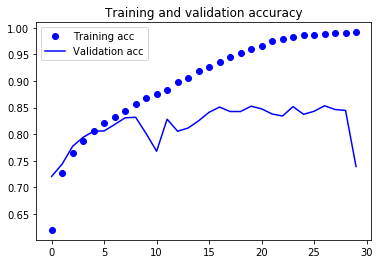

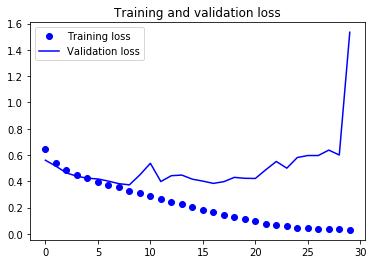

In [11]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

在验证集上的分类准确率大概为85%左右,moxing guo ni he。

### 使用数据增强技术
如果使用这个数据增强的配置来训练一个新的网络，是不会有两次相同的输入的。但是，这些输入仍然是相互关联的，因为它们来自少量的原始图像，我们不能产生新的信息，而只能重新混合现有的信息。因此，这可能不足以完全摆脱过度拟合。为了进一步克服过度拟合，我们还将在我们的模型中全连接层分类器的前面添加一个dropout层：

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=100,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=100,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=200,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/100
200/200 [==============================] - 198s 989ms/step - loss: 0.6648 - acc: 0.5855 - val_loss: 0.5860 - val_acc: 0.6982
Epoch 2/100
200/200 [==============================] - 187s 935ms/step - loss: 0.6079 - acc: 0.6641 - val_loss: 0.5431 - val_acc: 0.7274
Epoch 3/100
200/200 [==============================] - 188s 938ms/step - loss: 0.5837 - acc: 0.6867 - val_loss: 0.5620 - val_acc: 0.7120
Epoch 4/100
200/200 [==============================] - 189s 945ms/step - loss: 0.5594 - acc: 0.7083 - val_loss: 0.5081 - val_acc: 0.7554
Epoch 5/100
200/200 [==============================] - 189s 943ms/step - loss: 0.5459 - acc: 0.7208 - val_loss: 0.4756 - val_acc: 0.7774
Epoch 6/100
200/200 [==============================] - 188s 940ms/step - loss: 0.5333 - acc: 0.7306 - val_loss: 0.4770 - val_acc: 0.7746
Epoch 7/100
200/200 [==============================] - 187s 933ms/step - loss: 0.5230 - acc: 

Epoch 60/100
200/200 [==============================] - 189s 944ms/step - loss: 0.2582 - acc: 0.8922 - val_loss: 0.2212 - val_acc: 0.9144
Epoch 61/100
200/200 [==============================] - 190s 950ms/step - loss: 0.2642 - acc: 0.8869 - val_loss: 0.2134 - val_acc: 0.9158
Epoch 62/100
200/200 [==============================] - 187s 933ms/step - loss: 0.2587 - acc: 0.8916 - val_loss: 0.2120 - val_acc: 0.9148
Epoch 63/100
200/200 [==============================] - 186s 931ms/step - loss: 0.2582 - acc: 0.8918 - val_loss: 0.2235 - val_acc: 0.9148
Epoch 64/100
200/200 [==============================] - 189s 946ms/step - loss: 0.2538 - acc: 0.8938 - val_loss: 0.2316 - val_acc: 0.9096
Epoch 65/100
200/200 [==============================] - 189s 943ms/step - loss: 0.2517 - acc: 0.8947 - val_loss: 0.2116 - val_acc: 0.9166
Epoch 66/100
200/200 [==============================] - 192s 960ms/step - loss: 0.2408 - acc: 0.8995 - val_loss: 0.2329 - val_acc: 0.9058
Epoch 67/100
200/200 [============

In [14]:
model.save('cats_vs_dogs_basic_2.h5')

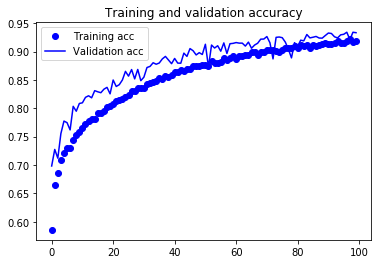

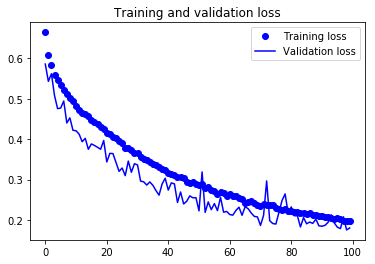

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
from keras.preprocessing import image
from keras import backend as K
import numpy as np


img_name = '241.jpg'
test_dir = os.path.join(base_dir, 'test_dir/test')
img_path = os.path.join(test_dir, img_name)

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)

# transform numpy array into a 'batch'
x = np.expand_dims(x, axis=0)

x = x/255

In [20]:
preds = model.predict(x)
print(preds)

[[0.99999523]]


In [23]:
output = model.output[0]
print(output)

Tensor("strided_slice:0", shape=(1,), dtype=float32)


In [35]:
# the output feature map of the 'conv2d_4' layer
last_conv_layer = model.get_layer('conv2d_4',7)

# the gradient of 'dog' class with regard to the output feature map of 'conv2d_4'
grads = K.gradients(output[0], last_conv_layer.output)[0]

# a vector of shape (128,), where each entry is 
# the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(128):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

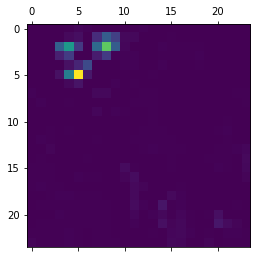

In [36]:
plt.matshow(heatmap)

In [38]:
import cv2

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('dog_cam.jpg', superimposed_img)

True